In [1]:
%load_ext autoreload
%autoreload 2

## AGN DCR Metric
This notebook build upon the prototype shown in [DCR_AGN_metric_analysis.ipynb](https://github.com/RichardsGroup/LSSTprep/blob/master/DCR/DCR_AGN_metric_analysis.ipynb) but with a focus on the integration with MAF and provide the ability to use more realistic astrometric errors simulated by OpSim. 

### 0. Software Setup

In [2]:
your_username = 'ywx649999311'

In [3]:
# import matplotlib to show plots inline.wfd_depth_scale0.95_v1.5_10yrs.db
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

Import the sims_maf modules needed.

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

# import convenience functions
from opsimUtils import *

In [5]:
from dask.distributed import Client
client = Client(n_workers=16)
client

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Client Scheduler: tcp://127.0.0.1:40964,Cluster Workers: 16 Cores: 16 Memory: 257.77 GB


## 1. The Metric

### 1.2 Define the metric

In [39]:
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils.astrometryUtils import m52snr, astrom_precision

class AGN_DCR(BaseMetric):
    """AGN DCR"""
    
    def __init__(self, band, src_mag=22, seeingCol='seeingFwhmGeom', m5Col='fiveSigmaDepth',
                 PACol='paraAngle', filterCol='filter', atm_err=0.01, **kwargs):
        
        self.band = band # required
        self.src_mag = src_mag
        self.m5Col = m5Col
        self.PACol = PACol
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.atm_err = 0.01
        self.metricName = f'DCR_{src_mag}_{self.band}'
        
        cols=['airmass', self.filterCol, self.m5Col, self.PACol, self.seeingCol]
        super(AGN_DCR, self).__init__(col=cols, metricName=self.metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # get the data only corresponding the the desired filter
        data_filt = dataSlice[np.where(dataSlice[self.filterCol] == self.band)]
        
        # compute snr and astrometric precision for given data slice
        snr = m52snr(self.src_mag, data_filt[self.m5Col])
        pos_var = np.power(astrom_precision(data_filt[self.seeingCol], snr), 2) \
                  + self.atm_err**2
        pos_err = np.sqrt(pos_var)
        
        # compute tan(Z), note that we might change sin(PA)
        zenith = np.arccos(1/data_filt['airmass'])
        x_coord = np.tan(zenith)*np.sin(np.radians(dataSlice[self.PACol]))
        x_coord2 = np.tan(zenith)*np.cos(np.radians(dataSlice[self.PACol]))
        # Things should be the same for RA and dec.
        # Now I want to compute the error if I interpolate/extrapolate to +/-1.

        # function is of form, y=ax. a=y/x. da = dy/x.
        # Only strictly true if we know the unshifted position. But this should be a reasonable approx.
        slope_uncerts = pos_err/x_coord
        slope_uncerts2 = pos_err/x_coord2

        total_slope_uncert = 1./np.sqrt(np.sum(1./slope_uncerts**2)+np.sum(1./slope_uncerts2**2))

        # So, this will be the uncertainty in the RA or Dec offset at x= +/- 1. A.K.A., the uncertainty in the slope
        # of the line made by tan(zd)*sin(PA) vs RA offset
        # or the line tan(zd)*cos(PA) vs Dec offset
        # Assuming we know the unshfted position of the object (or there's little covariance if we are fitting for both)
        result = total_slope_uncert

#         ## version from Bevington page 109 from least-square
#         Delta = np.sum(1/pos_var)*np.sum(x_coord**2/pos_var) - np.power(np.sum(x_coord/pos_var), 2)
#         result = np.sqrt(np.sum(x_coord**2/pos_var)/Delta)
        
        return result

/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metrics/baseMetric.py:39: UserWarning: Redefining metric __main__.AGN_DCR! (there are >1 metrics with the same name)
  warnings.warn('Redefining metric %s! (there are >1 metrics with the same name)' % (metricname))


In [42]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
outDir = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/0807/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/0807/MetricData/'

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))
    
if not os.path.exists(os.path.abspath(metricDataPath)):
    os.makedirs(os.path.abspath(metricDataPath))

In [18]:
dbRuns = show_opsims(dbDir)
dbRuns[0:5] # only show first 5 opsims

['dcr_nham1_ugri_v1.5_10yrs',
 'rolling_mod6_sdf_0.20_v1.5_10yrs',
 'wfd_depth_scale0.95_noddf_v1.5_10yrs',
 'u60_v1.5_10yrs',
 'footprint_stuck_rollingv1.5_10yrs']

### Select one OpSim from each family

In [28]:
dbFamil = [run.split('_')[0] for run in dbRuns]
dfRuns = pd.DataFrame({'run':dbRuns, \
                       'runFamil':dbFamil}).sort_values(by='runFamil').reset_index(drop=True)
dfRuns.head()

,run,runFamil
0,agnddf_v1.5_10yrs,agnddf
1,alt_dust_v1.5_10yrs,alt
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs,alt
3,baseline_2snaps_v1.5_10yrs,baseline
4,baseline_v1.5_10yrs,baseline


In [30]:
# pick on run from each family
dfRunPick = dfRuns.drop_duplicates(subset=['runFamil']).reset_index(drop=True)
dfRunPick.head()

,run,runFamil
0,agnddf_v1.5_10yrs,agnddf
1,alt_dust_v1.5_10yrs,alt
2,baseline_2snaps_v1.5_10yrs,baseline
3,bulges_cadence_bs_v1.5_10yrs,bulges
4,daily_ddf_v1.5_10yrs,daily


In [34]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir, dbRuns=dfRunPick.run.values)

### 3. Declare metrics to for gMag = [22, 23 ,24]

In [40]:
bundleDict = {}
for gMag in [19, 21, 23, 25]:
    
    # declare metric, slicer and sql contraint
    DCR_metricG = AGN_DCR('g', src_mag=gMag)
    slicer = slicers.HealpixSlicer(nside=64)
    constraintG = 'filter = "g"'
    constraintG += ' and note not like "DD%"'
    constraintG += ' and proposalId = 1'
    
    # make a bundle
    DCR_mbG = metricBundles.MetricBundle(DCR_metricG, slicer, constraintG)
    summaryMetrics = [metrics.MedianMetric(), metrics.MeanMetric(), metrics.RmsMetric()]
    DCR_mbG.setSummaryMetrics(summaryMetrics)
    
    # declare u band metric
    DCR_metricU = AGN_DCR('u', src_mag=gMag+0.15)
    constraintU = 'filter = "u"'
    constraintU += ' and note not like "DD%"'
    constraintU += ' and proposalId = 1'
    
    # make a bundle
    DCR_mbU = metricBundles.MetricBundle(DCR_metricU, slicer, constraintU)
    DCR_mbU.setSummaryMetrics(summaryMetrics)

    # put into dict
    bundleDict[DCR_metricG.metricName] = DCR_mbG
    bundleDict[DCR_metricU.metricName] = DCR_mbU

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### 4. Loop over all OpSims in dbDir and run MAF
While constructing a metricBundleGroup from a dictionary (the cell below), you will need to provide the path to a directory (`metricDataPath` in the cell below) where you would like to store the metric data (this is **DIFFERENT** than path to the metric data, `outDir`). To construct metricbundles for plotting and further analysis, this path will be needed.

In [ ]:
# # below I am only going to run metrics on the first five opsims
# for run in dbRuns[0:3]:
#     # must set run name for each opSim to store metric data into
#     # separate files
#     print(f'Running metrics on: {run}')
#     print('*************************************')
#     for key in bundleDict:
#         bundleDict[key].setRunName(run)
        
#     metricGroup = metricBundles.MetricBundleGroup(bundleDict,\
#                     opSimDbs[run], metricDataPath, resultDbs[run], verbose=False)
#     metricGroup.runAll()

### 4.1 Or run it with Dask (installing Dask.distributed is required)

In [43]:
def run_mg(run, bundleDict, dbDir, outDir, metricDataPath):
        
    for key in bundleDict:
        bundleDict[key].setRunName(run)
    
    opSimDb, resultDb = connect_dbs(dbDir, outDir, dbRuns=[run])
    metricGroup = metricBundles.MetricBundleGroup(bundleDict, opSimDb[run], metricDataPath, \
                                                  resultDb[run], verbose=False)
    metricGroup.runAll()

# %%time
rt = []
for run in dfRunPick.run.values:
    r = client.submit(run_mg, run, bundleDict, dbDir, outDir, metricDataPath)
    rt.append(r)
result = client.gather(rt)

** ---------- Ignore below summary stat ------------------**
---

#### 5.1 Summary statistics for `uMagErrMean_23`

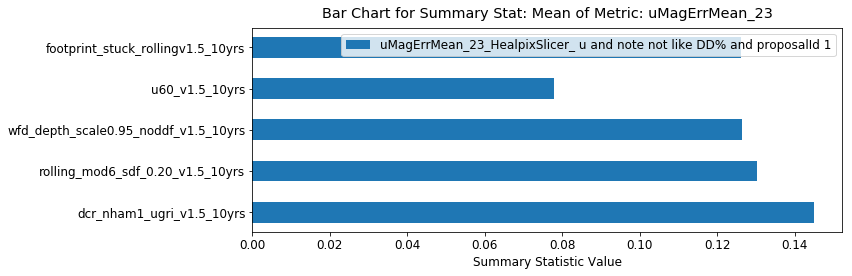

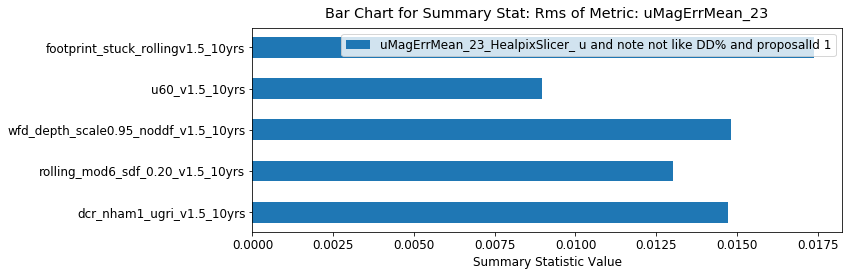

In [28]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'uMagErrMean_23', 'Mean', runNames=dbRuns[0:5])

# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'uMagErrMean_23', 'Rms', runNames=dbRuns[0:5])

#### 5.2 Summary statistics for `gMagErrMean_23`

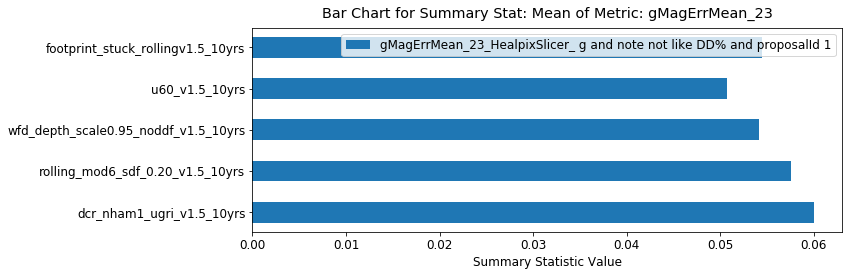

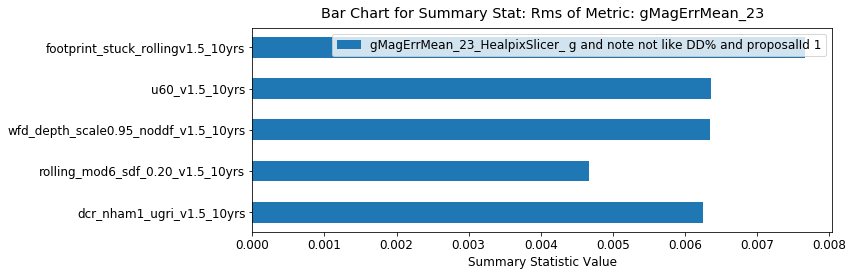

In [29]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'gMagErrMean_23', 'Mean', runNames=dbRuns[0:5])

# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'gMagErrMean_23', 'Rms', runNames=dbRuns[0:5])

### 6. Look at the distribution `gMagErrMean_23` over the Sky and a histogram

In [30]:
get_metricMetadata(resultDbs[dbRuns[0]])

,metricId,metricName,slicerName,sqlConstraint,metricMetadata,metricDataFile
0,1,uMagErrMean_23,HealpixSlicer,"filter = ""u"" and note not like ""DD%"" and propo...",u and note not like DD% and proposalId 1,dcr_nham1_ugri_v1_5_10yrs_uMagErrMean_23_u_and...
1,2,gMagErrMean_23,HealpixSlicer,"filter = ""g"" and note not like ""DD%"" and propo...",g and note not like DD% and proposalId 1,dcr_nham1_ugri_v1_5_10yrs_gMagErrMean_23_g_and...


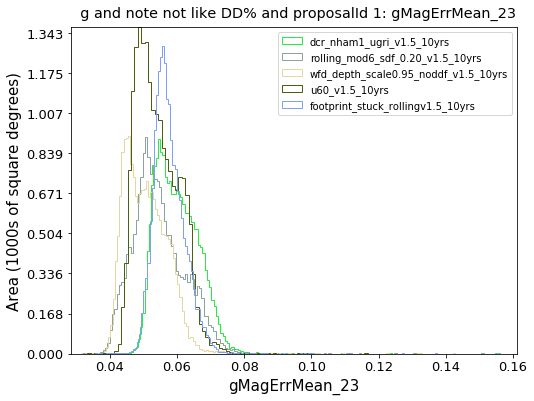

In [34]:
plotHist(bundleDicts, (2, 'gMagErrMean_23'))